# 2023-08-30 8 - dev-explore-electricity.ipynb
Explore some electricity dev runs

## Fetching runs

In [42]:
import wandb
from math import isnan 
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import wandb
from tqdm import tqdm
# from cycler import cycler
import matplotlib as mpl
from IPython.display import Markdown, display
    
api = wandb.Api()
project = "Autoformer-javierdev"
workspace = "alelab"

run_ids = ['t1ngphzp','1eusm0ma']

runs = [api.run(f"{workspace}/{project}/runs/{run_id}")for run_id in run_ids]

all_runs = []
run_counter = 0
for run in tqdm(runs):
    run_counter += 1
    for split in ["train", "test","val"]:
        for metric in ["mse",]:
            pred_len = run.config["pred_len"]
            metrics = np.zeros(pred_len)
            for i in range(pred_len):
                run_dict = {**run.config}
                #run_dict["constraint_level"] = constraint_level
                run_dict[f"{metric}"] = run.summary[f"{metric}/{split}/{i}"]
                #run_dict[f"{metric}"] = run.summary.get(f"{metric}/{split}/{i}",run.summary.get(f"mse/{split}/{i}",np.nan)) #god forgive me for this line
                run_dict["step"]=i
                run_dict["epoch"]=run.summary["epoch"]
                run_dict["infeasible_rate"]=run.summary[f"infeasible_rate/{split}"]
                run_dict["split"] = split
                run_dict["run_id"] = run.id
                # Get either Constrained/ or ERM/ from the run name, then append model name.
                #print("run.name", run.name)
                #debug if ERM run
                run_dict["Algorithm"] = f"{run.name.split('/')[0]} {run.config['model']}"
                run_dict["sweep_id"] = run.sweep.id if run.sweep else ''
                #print("Algorithm", run_dict["Algorithm"])

                # To better plot constrained vs ERM
                #TODO this is a hack while I consolidate the tags. 
                run_dict["type"] = "ERM" if run.config['dual_lr'] == 0 else "Constrained"

                all_runs.append(run_dict)
print(f"Fetched {run_counter} runs")
df = pd.DataFrame(all_runs)
print(f"Total records: {(df.shape)}")

100%|██████████| 1/1 [00:00<00:00, 224.04it/s]

Fetched 1 runs
Total records: (288, 60)


There should be 3 runs per model, per pred length (3 x 2 x 4 = 24), plus ERM runs: 2 per model per pred_len (2 x 4 = 8) Total 32. 

In [16]:
df[['run_id',"sweep_id",'Algorithm','model','constraint_level','pred_len','epoch']].drop_duplicates().sort_values(["pred_len",'Algorithm','model',"constraint_level"])

,run_id,sweep_id,Algorithm,model,constraint_level,pred_len,epoch
0,t1ngphzp,,Constrained-Autoformer-electricity Autoformer,Autoformer,0.2625,96,1


## Plots

[0.2625]


### pred_len: 96 constraint_level: 0.2625

,pred_len,constraint_level,Algorithm,epoch,0
0,96,0.2625,Constrained-Autoformer-electricity Autoformer,1,96


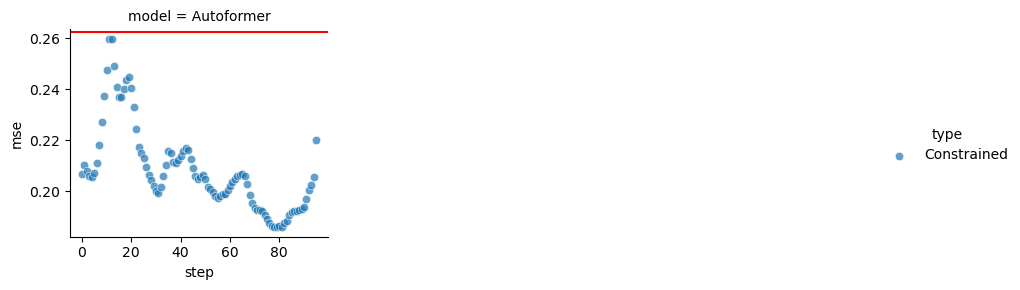

In [17]:
to_plot = df[df.split=='test']# just see test to unclutter
#to_plot=df
for (pred_len), series in to_plot.groupby(["pred_len"]):
    constraints = series.constraint_level.unique()
    print(constraints)
    constraints = constraints[constraints!=-1] # to iterate over all constraints explored.
    for constraint_level in constraints:
        display(Markdown(f"### pred_len: {pred_len} constraint_level: {constraint_level}"))
        plot_series = series[series["constraint_level"].isin([constraint_level,-1])] # The -1 adds the ERM baseline.

        display(plot_series.groupby(['pred_len','constraint_level','Algorithm','epoch']).size().reset_index())

        # sns.scatterplot(x="step", y="mse", hue="Algorithm",style="split", data=plot_series)
        
        # plt.axhline(y=constraint_level, color='r', linestyle='-')
        # plt.title(f"Pred Length: {pred_len}, Constraint_level: {constraint_level}")
        # plt.show()

        # This same scatterplot but in a grid by algorithm. 
        g = sns.FacetGrid(plot_series, col="model", hue="type",col_wrap=3)
        g.map(sns.scatterplot, "step", "mse", alpha=.7) 
        g.add_legend()
        # add the hline
        for ax in g.axes:
            ax.axhline(y=constraint_level, color='r', linestyle='-')
        plt.show()


## Distribution of ERM?

In [27]:
all_runs.query("split=='val'").groupby(['pred_len'])['loss'].describe()

ValueError: index must be a MultiIndex to unstack, <class 'pandas.core.indexes.numeric.Int64Index'> was passed

In [45]:
all_runs = df
stats=all_runs.query("split=='val'").groupby(['pred_len'])['mse'].describe()
stats.transpose()

pred_len,96
count,96.000000
mean,0.208253
std,0.017036
min,0.185825
25%,0.197886
50%,0.205653
75%,0.214017
max,0.259756
